# Demo: Numpy Dataset

In [1]:
import autoroot
from typing import Optional, Callable
import toolz 
import functools as ft
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm.auto as tqdm
from rastervision.core.data import RasterioSource
from typing import Optional, Callable
from torch.utils.data import Dataset, DataLoader
import rasterio as rio
from os import PathLike
from PIL import Image
from os.path import splitext
from pathlib import Path

sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)

%matplotlib inline
%load_ext autoreload
%autoreload 2

2023-11-21 07:11:56:rastervision.pipeline.rv_config: WARNING - Root temporary directory cannot be used: /opt/data/tmp. Using root: /tmp/tmpdxrlf0i3


In [2]:
from helio_tools._src.utils.io import get_list_filenames

base_path = "/home/juanjohn/data/helio/sdo_png/304"
ext = ".png" 

data_filenames = get_list_filenames(base_path, ext)
print(len(data_filenames))


50


In [3]:



def load_image(path: PathLike) -> np.ndarray:
    """Read in image from path and return as a (H, W, C) numpy array."""
    # get extension
    ext = Path(path).suffix
    if ext == '.npy':
        img = np.load(path, mmap_mode="r+")
    elif ext in ['.tif', '.tiff']:
        with rio.open(path, 'r') as f:
            img = f.read()
            img = img.transpose(1, 2, 0)
    else:
        img = np.array(Image.open(path))

    return _make_2D(img)

def _make_2D(img: np.ndarray) -> np.ndarray:
    if img.ndim == 2:
        # (h, w) --> (h, w, 1)
        img = img[..., np.newaxis]

    return img


In [4]:
out = load_image(data_filenames[0])
out.shape

(2048, 2048, 1)

In [5]:


class ImageDataReader(Dataset):
    def __init__(self, data_dir: str, ext: str=".npy", transforms: Optional[Callable]=None):
        self.data_dir = data_dir
        self.data_filenames = get_list_filenames(data_dir, ext)
        self.transforms = transforms

    def __getitem__(self, ind) -> np.ndarray:
        img_path = self.data_filenames[ind]
        x = load_image(img_path)
        if self.transforms is not None:
            x = self.transforms(x)
        return x

    def __len__(self):
        return len(self.data_filenames)

    def sample(self, n_samples):
        it = DataLoader(self, batch_size=1, shuffle=True, num_workers=4).__iter__()
        samples = []
        while len(samples) < n_samples:
            try:
                samples.append(next(it).detach().numpy())
            except Exception as ex:
                logging.error(str(ex))
                continue
        del it
        return np.concatenate(samples)

In [6]:
import einops
import toolz
from sklearn.feature_extraction.image import extract_patches_2d
data_dir = "/home/juanjohn/data/helio/sdo_npy/304"
ext = ".npy" 


ds = ImageDataReader(data_dir, ext=ext, transforms=None)

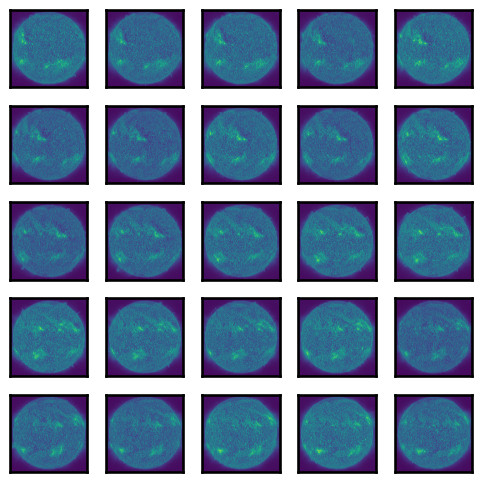

In [7]:
fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(5,5))

for idx, iaxes in enumerate(ax.ravel()):
    iaxes.imshow(ds[idx])
    iaxes.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

plt.tight_layout()
plt.show()

### Sampling

In [13]:
from loguru import logger
def sample_numpy_dataset(ds: Dataset, n_samples: int=2, num_workers: int=1, **kwargs) -> np.ndarray:
    # initialize dataloader
    it = DataLoader(ds, batch_size=1, shuffle=True, num_workers=num_workers, **kwargs).__iter__()
    samples = []
    while len(samples) < n_samples:
        try:
            out = next(it)
            samples.append(out.detach().numpy())
        except Exception as ex:
            logger.error(str(ex))
            break
    del it
    return np.concatenate(samples)

In [14]:
n_samples: np.ndarray = sample_numpy_dataset(ds, n_samples=25, num_workers=1)

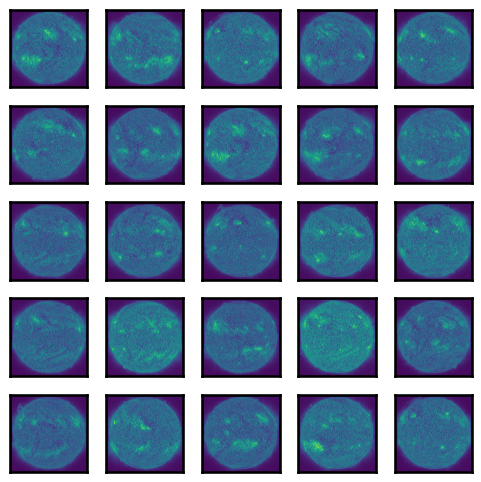

In [15]:
fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(5,5))

for idx, iaxes in enumerate(ax.ravel()):
    iaxes.imshow(n_samples[idx])
    iaxes.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

plt.tight_layout()
plt.show()

### Patching

In [16]:
def random_patch_2D(x: np.ndarray, patch_size: tuple[int, int], **kwargs) -> np.ndarray:
    assert x.ndim >= 2 or x.ndim <= 3

    x = extract_patches_2d(x, patch_size=patch_size, max_patches=1, **kwargs)[0]

    return _make_2D(x)

In [17]:
patch_size = (256, 256)

In [19]:
# ds[0]

In [20]:
out = random_patch_2D(ds[0], patch_size, random_state=123)

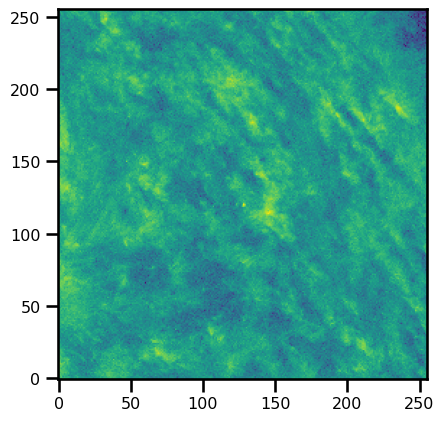

In [21]:
fig, ax = plt.subplots()

ax.imshow(out[...,0].T, origin="lower")

plt.show()

### Altogether

In [22]:
# perform patching
fn1 = toolz.partial(random_patch_2D, patch_size=patch_size, random_state=None)

# do reshaping
fn2 = lambda x: einops.rearrange(x, "H W 1 -> 1 H W")

In [23]:
transforms = toolz.compose_left(fn1, fn2)

In [24]:
# initialize dataset
ds = ImageDataReader(data_dir, ext=ext, transforms=transforms)

# initialize dataloader
batch_size = 32
dl = DataLoader(ds, batch_size=batch_size, shuffle=None)
ibatch = next(iter(dl))

In [25]:
import torch 

def torch_to_numpy(data: torch.Tensor) -> np.ndarray:
    return data.detach().numpy().transpose(1, 2, 0)

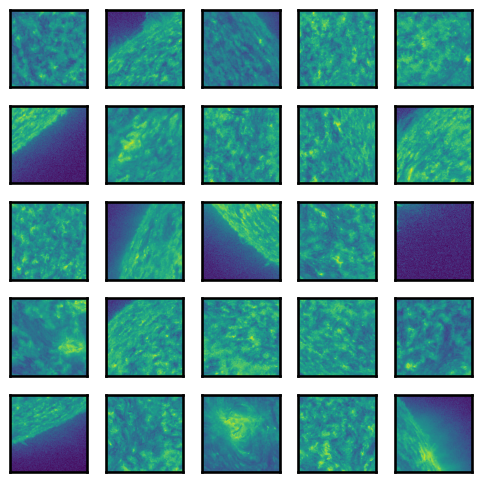

In [26]:
fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(5,5))

for idx, iaxes in enumerate(ax.ravel()):
    iaxes.imshow(torch_to_numpy(ibatch[idx]))
    iaxes.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

plt.tight_layout()
plt.show()

### Sampling

In [27]:
n_samples: np.ndarray = sample_numpy_dataset(ds, n_samples=25, num_workers=1)
n_samples.shape

(25, 1, 256, 256)

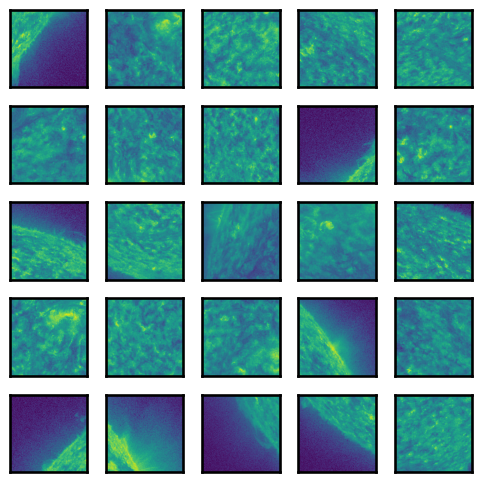

In [28]:
fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(5,5))

for idx, iaxes in enumerate(ax.ravel()):
    iaxes.imshow(n_samples[idx].transpose(1,2,0))
    iaxes.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

plt.tight_layout()
plt.show()

## Configs

In [29]:
from hydra_zen import make_custom_builds_fn, builds, instantiate, to_yaml, load_from_yaml, save_as_yaml

pbuilds = make_custom_builds_fn(zen_partial=True, populate_full_signature=True)

In [30]:
train_transforms = builds(
    toolz.compose_left,
    pbuilds(random_patch_2D, patch_size=patch_size, random_state=None),
    pbuilds(einops.rearrange, pattern="H W 1 -> 1 H W")
)

DS = builds(
    ImageDataReader,
    data_dir=base_path,
    ext=".png",
    transforms=train_transforms
)

In [31]:
cfg = to_yaml(DS)

In [32]:
# save to a yaml file
config_path = "./SDO_DS_config.yaml"
save_as_yaml(DS, f=config_path)

In [33]:
# initialize config
config = load_from_yaml(config_path)

# load config
out = instantiate(config)

In [34]:
train_transforms

types.Builds_compose_left